In [1]:
#Fix Variance and utility arrays for different strategies

import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import weibull_min
from scipy.signal import spectrogram
from numpy import log as ln
import networkx as nx
import pandas as pd
import bisect
import seaborn as sns
import sympy as sp
from sympy import symbols, Eq, solve
import json
from time import process_time
import sys
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import seaborn as sns
import pandas as pd
import ptitprince
import os

# Overall Model Parameters

In [2]:
#Fixed parameters
sensitivity_steps = 1 #Number of parameter values scanned for sensitivity parameter specified below
simulations = 100
annual_decisions = 4 #Number of times an agent is evaluating strategy on average
households = 100
time = 20000
mu_farm = 260.9 #For cereal crops only 176.5 #For all crops 260.93 #Previously mu_farm = 163.4
farm_k = 0.798 #For cereal crops only 1.31 #For all crops 0.798 #For STD = 321; previously k = 0.808 #Shape factor for farming income distribution (Weibull)
max_farm = 2500 #For cereal crops only: 732.1 #For combined: 2500 #99th percentile of farm income/cycle (in USD) to truncate Weibull - based on CVFS total revenues
eta = 0.9 #Proportion of full farm income that is still earned by households engaging in migration
cost_farm = 221.3 #170


migration_type = 'International'

if migration_type == 'International':
    mu_migrate =   600.8 #Without 0's 1016 #CVFS average with 0s included 872.2 #664.9 from CVFS Data #600.8 from Shrestha data - combined #For intl only 872.2 
    var_migrate = 648.8 ** 2 #Without 0's 1083 ** 2 #From CVFS data with 0's 825.8 ** 2 #For intl only: 825.8 ** 2 #For combined: 648.8 ** 2 #Oriignal 998.2 ** 2
    cost_migrate = 999999999 #700.6 #Weighted Avg from Shrestha 700.6 #For intl only:1133 #500
    
elif migration_type == 'Local':
    mu_migrate = 200 
    var_migrate = 190 ** 2 
    cost_migrate = 62.5

else: 
    raise ValueError ('Migration type improperly specified')
    

subsidy = 0 #Subsidy on cost of insurance premium
matching = 0 #Amount of matching dollars government contributes to revenue-sharing pools, per hh per cycle

beta = 0.2 #Proportion of income that is shared in collective
objective_drought = 0.2 #Presumed drought risk in 2021, to set income threshold for drought vs. non-drought year
p_drought = 0.2 #This can vary based on severity of climate risk that is to be modelled
p_cov = 0.1 #Pearson's correlation coefficient for farming (i.e. covariate risk)
rho_mig = 0.0 #Pearson's correlation coefficient for farming and migration income streams
init_insure = 0.00 #Initial adopters of insurance

discount_rate = 0.2
time_horizon = 10 #Number of cycles across which a household evaluates options

utility_function = 'Self-Interested'

risk_factor = 0.5
altruism_factor = 0.0 #Degree to which individuals account for other households' utility, should range from [0,1]
max_altruism = 1 #Scalar by which others' utilities are multiplied, before applying altruism factor. Can take on any non-zero number. 1 = household caring about the sum of other households equally to their own for altruism factor = 1. 

k = 0.0 #Probability of an agent following another agent
sel_strength = 27.73 #Strength of selection effect; 27.73 gives 80% change of switching for relative utility gap of 5%
mutation_rate= 1 /households #1 / households



# Model Functions

## Calculating Variances of Drought and Non-Drought Income Distributions

In [3]:
#Calculate variance of truncated distributions (for drought vs. non-drought distributions)
def trunc_var(income_sample, mu):
    running_var = 0
    N = len(income_sample)
    for i in range(N):
        running_var += (income_sample[i] - mu) ** 2
    
    var = running_var / (N - 1)
    
    return var

#Define drought and non-drought portions of farming income distribution
def farm_drought_0(adj_k, adj_scale, p_drought, max_farm):
    
    new_dist = adj_scale * np.random.weibull(adj_k, size=10000)
    adj_income = list(np.sort(new_dist))
    
    adj_drought_index = int(p_drought * len(adj_income))
    adj_nondrought_incomes = np.array(adj_income[adj_drought_index:len(adj_income)]).astype(float)
    
    if p_drought == 0:
        adj_drought_incomes = adj_nondrought_incomes
    else:
        adj_drought_incomes = np.array(adj_income[0:adj_drought_index]).astype(float)
    
    mu_farm_drought = np.average(adj_drought_incomes)
    mu_farm_nd = np.average(adj_nondrought_incomes)
    mu_farm = np.average(np.array(adj_income).astype(float))
    
    var_drought = trunc_var(adj_drought_incomes, mu_farm)
    var_nd = trunc_var(adj_nondrought_incomes, mu_farm)
    
    uninsured_var = trunc_var(adj_income, mu_farm)
    
    #Adjusting income distribution during drought years for insurance holders
    payout_distribution = adj_drought_incomes + (mu_farm_nd - mu_farm_drought)
    payout_var = trunc_var(payout_distribution, mu_farm_nd) 
    insured_var = p_drought * payout_var + (1 - p_drought) * var_nd
    
    return mu_farm_drought, mu_farm_nd, uninsured_var, insured_var

#Split Weibull distribution into drought and non-drought portions (for income draws)
def weib_split(adj_k, adj_scale, p_drought, max_farm):
    
    new_dist = adj_scale * np.random.weibull(adj_k, size=10000)
    adj_income = list(np.sort(new_dist))
    
    adj_drought_index = int(p_drought * len(adj_income))
    adj_nondrought_incomes = np.array(adj_income[adj_drought_index:len(adj_income)]).astype(float)
    
    if p_drought == 0:
        adj_drought_incomes = adj_nondrought_incomes
    else:
        adj_drought_incomes = np.array(adj_income[0:adj_drought_index]).astype(float)

    return adj_nondrought_incomes, adj_drought_incomes

#Draw from either drought or non-drought portion of Weibull distribution
def weib_draw(drought_incomes, nondrought_incomes, p, p_drought):
    
    if p < p_drought:
        i = np.random.randint(0,len(drought_incomes))
        sample = drought_incomes[i]
    else:
        i = np.random.randint(0, len(nondrought_incomes))
        sample = nondrought_incomes[i]
    
    return sample


#Adjust Weibull distribution parameters based on drought risk
def wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm):
    
    scale = (mu_farm / math.gamma(1 + 1 / farm_k))
    income_distribution = scale * np.random.weibull(farm_k, size=1000000)
    sorted_income = list(np.sort(income_distribution))
    drought_index = int(objective_drought * len(sorted_income)) - 1
    drought_threshold = sorted_income[drought_index]
        
    #Identify value of Weibull cdf that represents 99.99 percentile
    last_percent = max_farm
    
    x, y = symbols('x y')
    eq1 = Eq(1 - sp.exp(-(last_percent/ y) ** x), 0.9999)
    eq2 = Eq(1 - sp.exp(-(drought_threshold / y) ** x), p_drought)
    
    adj_k, adj_scale = solve((eq1, eq2), (x,y))[-1]
    
    return adj_k, adj_scale


#Calculate variance from Weibull distribution parameters
def wei_var(mu, k):
    scale = (mu / math.gamma(1 + 1 / k))
    variance = scale ** 2 * (math.gamma(1 + 2 / k) - (math.gamma(1 + 1 / k)) ** 2)
    return variance

def wei_scale(mean, shape):
    scale = (mean / math.gamma(1 + 1 / shape))
    
    return scale

#Function that returns Weibull shape parameter (k) from mean and std dev
def wei_shape(mean, std_dev):
    k = (std_dev / mean) ** -1.086
    
    return k

def lognorm_factors(mean, std_dev):
    mu = np.log(mean / math.sqrt(1 + std_dev ** 2 / mean ** 2))
    sigma = math.sqrt(np.log(1 + std_dev ** 2 / mean ** 2))
    
    return mu, sigma

#Function to calculate NPV of an array
def npv_calc(array, time_horizon, discount_rate):
    npv = 0
    
    for i in range(time_horizon):
        npv += array[i] / ((1 + discount_rate) ** i)
        
    return npv


def gini_calc(households, household_income):
    gini_sum = 0 
    community_total = 0
    
    #Setting household(i) income to 0 if it is negative
    for i in range(households):
        if household_income[i] < 0:
            agent_i_income = 0
        else:
            agent_i_income = household_income[i]
        
        #Adding difference in i and j income to running Gini total (if it hasn't already been compared)
        for j in range(households): 
            if j > i:
                if household_income[j] < 0:
                    agent_j_income = 0
                else:
                    agent_j_income = household_income[j]
                
                gini_sum += abs(agent_i_income - agent_j_income)
            
            else:
                gini_sum += 0
        
        community_total += agent_i_income

    community_avg_income = community_total / households
    
    if community_avg_income == 0:
        gini = gini_sum / (2 * 0.01 * households ** 2)
    else:
        gini = gini_sum / (2 * community_avg_income * households ** 2) 

    return gini


## Calculating Incomes and NPV of Income

In [4]:
#Calculate NPV based on annual income, costs, and discount rate
def income_horizon(time_horizon, strategy, strategy_cost, farm_income, shared_income, remittances, migration_cost, discount_rate):
    income = np.zeros(time_horizon)
    costs = np.zeros(time_horizon)
    
    #Accounting for different costs/income in initial time step of migration
    if 'Migrate' in strategy:
        costs[0] = strategy_cost
        income[0] = farm_income + shared_income
        for i in range(1, time_horizon):
            income[i] = farm_income + remittances + shared_income
            costs[i] = strategy_cost - migration_cost #Becuase strategy_costs captures costs related to all strategy components
    else:
        for i in range(0, time_horizon):
            costs[i] = strategy_cost
            income[i] = farm_income + remittances + shared_income
        
    return income, costs
        

# Calculate expected income from strategy options as a function of strategy distribution
def income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought, subsidy, matching, time_horizon, discount_rate):
    income_array = {key : 0 for key in strategy_names}
    cost_array = {key : 0 for key in strategy_names} 
    expected_payoffs = {key : 0 for key in strategy_names} 
    
    #Income generated by own household
    farm_income = {'Farm': p_drought * mu_farm_drought + (1 - p_drought) * mu_farm_nd, 
                     'FarmMigrate': eta * (p_drought * mu_farm_drought + (1 - p_drought) * mu_farm_nd), 
                     'Farm+Share': p_drought * mu_farm_drought + (1 - p_drought) * mu_farm_nd, 
                     'FarmMigrate+Share': eta * (p_drought * mu_farm_drought + (1 - p_drought) * mu_farm_nd), 
                     'Farm+Ins': mu_farm_nd, 
                     'FarmMigrate+Ins': mu_farm_nd * eta, 
                     'Farm+Share+Ins': mu_farm_nd, 
                     'FarmMigrate+Share+Ins': mu_farm_nd * eta}
    
    remittances = {'Farm': 0, 
                   'FarmMigrate': mu_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': mu_migrate, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': mu_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': mu_migrate}
    
    shared_pool = 0
    shared_dist = 0
    for item in strategy_names:
        #Check whehter we should adjust how much migrant households contribute/receive in shared income
        if 'Share' in item:
            shared_pool += beta * frequency_dist[item] * farm_income[item]
            shared_dist += frequency_dist[item]
    
    if shared_dist == 0:
        household_share = 0
    else:
        household_share = (shared_pool + shared_dist * matching) / shared_dist
        
    shared_income_received = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': household_share, 
                   'FarmMigrate+Share': household_share, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': household_share, 
                   'FarmMigrate+Share+Ins': household_share}
    
    costs = {'Farm': cost_farm, 
            'FarmMigrate': cost_farm + cost_migrate, 
            'Farm+Share': cost_farm + beta * farm_income['Farm+Share'], 
            'FarmMigrate+Share': cost_farm + cost_migrate + beta * farm_income['FarmMigrate+Share'], 
            'Farm+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought) - subsidy, 
            'FarmMigrate+Ins': cost_farm + cost_migrate + p_drought * eta * (mu_farm_nd - mu_farm_drought) - subsidy, 
            'Farm+Share+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought) + beta * farm_income['Farm+Share+Ins'] - subsidy, 
            'FarmMigrate+Share+Ins': cost_farm + cost_migrate + p_drought * eta * (mu_farm_nd - mu_farm_drought) + beta * farm_income['FarmMigrate+Share+Ins'] - subsidy}
    
    for item in strategy_names:
        income_array[item], cost_array[item] = income_horizon(time_horizon, item, costs[item], farm_income[item], shared_income_received[item], remittances[item], cost_migrate, discount_rate)
        expected_payoffs[item] = income_array[item] - cost_array[item]
    
    return expected_payoffs
        

## Calcluating Variances and NPV of Variance

In [5]:
#NOTE - ensure combined variance accounts for covariance between all players of the same strategy

#Variance calculation - calls upon combined_variance and npv_variance functions
def variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, frequency_dist, households, p_cov, strategy_names, time_horizon, discount_rate):
    std_array = {key : 0 for key in strategy_names}
    
    var_farm = wei_var(mu_farm, farm_k)
    
    #Farming income variance, before accounting for shared pool
    base_farm_variance = {'Farm': uninsured_var, 
                   'FarmMigrate': (eta ** 2) * uninsured_var, 
                   'Farm+Share': uninsured_var, 
                   'FarmMigrate+Share': (eta ** 2) * uninsured_var, 
                   'Farm+Ins': insured_var, 
                   'FarmMigrate+Ins': (eta ** 2) * insured_var, 
                   'Farm+Share+Ins': insured_var, 
                   'FarmMigrate+Share+Ins': (eta ** 2) * insured_var} 
    
    
    #Remittance income variance before accounting for shared pool
    base_remittance_variance = {'Farm': 0, 
                   'FarmMigrate': var_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': var_migrate, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': var_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': var_migrate}
    
    
  
    #for key in strategy_names:
        #base_combined_var[key] = base_farm_variance[key] + base_remittance_variance[key] + 2 * rho_mig * math.sqrt(base_farm_variance[key]) * math.sqrt(base_remittance_variance[key])
        
    
    #Calculating variance of shared strategies
    pool_dist = 0
    for item in strategy_names:
        if 'Share' in item:
            pool_dist += frequency_dist[item]
    
    total_farm_variance = {key: 0 for key in strategy_names}
    total_variance = {key : 0 for key in strategy_names}
    total_std = {key : 0 for key in strategy_names}
    
    for item in strategy_names:
        if 'Share' in item and frequency_dist[item] != 0:
            total_farm_variance[item] = combined_variance(beta, pool_dist, households, p_cov, base_farm_variance, item, frequency_dist, strategy_names)

        else:
            total_farm_variance[item] = base_farm_variance[item]   
        
        #Adding farm and remittance variances
        total_variance[item] = total_farm_variance[item] + base_remittance_variance[item]
        total_std[item] = math.sqrt(total_variance[item])
        
        #Calculates NPV of Standard Deviation
        std_array[item] = std_horizon(time_horizon, item, total_std, discount_rate)
    return std_array

#Function that calculates combined variance for sharing pool between income streams A and B, given correlation coefficient p_cov
def combined_variance(beta, pool_dist, households, p_cov, individual_variance, strategy_a, frequency_dist, strategy_names):
    #Note - strategy_a reflects the strategy that is being played by the household. This is important for keeping track of how many other households are playing the same strategy in the shared pool. 
    
    #Converting proportion of participants in pool to an integer
    pool_hh = pool_dist * households
    #Factors for kept, shared, and received variances
    kept = (1 - beta) #Factor for portion of a household's income that is kept (i.e. not shared with pool)
    shared = beta / pool_hh #Should a square root be in the denominator? Factor for portion of a household's income that is initially shared to pool and returned to household 
    
    #Variance and Covariance of kept and shared portions from household's own income
    own_covariance = (kept ** 2 + shared ** 2  + (2 * kept * shared)) * individual_variance[strategy_a]
    
    #Creating Covariance matrix
    shared_strategies = []
    for name in strategy_names:
        if 'Share' in name:
            shared_strategies.append(name)
    
    covariance_matrix = {key : {} for key in shared_strategies}
    
    for row in shared_strategies:
        #Note - what about covariance in farm incomes between insured and non-insured strategies?
        covariance_matrix[row] = {column: p_cov for column in shared_strategies}
        
    #Covariance between a household's kept income (strategy_a) and income received from rest of the pool (item)
    contributed_cov = 0
    for item in shared_strategies:
        if item == strategy_a and frequency_dist[strategy_a] > 0:
            contributed_cov += 2 * covariance_matrix[strategy_a][item] * kept * beta * (frequency_dist[item] * households - 1) / pool_hh * math.sqrt(individual_variance[strategy_a]) * math.sqrt(individual_variance[item])

        else:
            contributed_cov += 2 * covariance_matrix[strategy_a][item] * kept * beta * frequency_dist[item] * households / pool_hh * math.sqrt(individual_variance[strategy_a]) * math.sqrt(individual_variance[item])
        
    
    #Variance and Covariance between income from other contributors within a pool that is received by a household
    pool_var = 0
    pool_cov = 0
    for i, row in enumerate(shared_strategies):
        X_i = frequency_dist[row] * households #Number of households playing strategy "row", a.k.a strategy "i"
        
        #Covariance of contributed amounts for same strategy
        if row == strategy_a and frequency_dist[strategy_a] > 0:
            pool_var += ((X_i - 1) * beta ** 2 / (pool_hh) ** 2 * individual_variance[row] + 2 * X_i * (X_i - 1) * covariance_matrix[row][row] * beta ** 2 / (2 * (pool_hh) ** 2) * individual_variance[row])
       
        elif frequency_dist[row] > 0:
            pool_var += ((X_i * beta ** 2 / (pool_hh) ** 2 * individual_variance[row]) + 2 * X_i * (X_i - 1) * covariance_matrix[row][row] * beta ** 2 / (2 * (pool_hh) ** 2) * individual_variance[row])
        
        #Covariance of contributed amounts between different strategies
        for j, column in enumerate(shared_strategies):
            if j < i:
                X_j = frequency_dist[column] * households #Number of households playing strategy "column", a.k.a strategy "j"
                pool_cov += ((2 * beta ** 2 * covariance_matrix[row][column] * X_i * X_j) / (2 * (pool_hh) ** 2) * math.sqrt(individual_variance[row]) * math.sqrt(individual_variance[column]))

    total_covariance = own_covariance + contributed_cov + pool_var + pool_cov
    
    return total_covariance

#Adjusted NPV calculation for standard deviation to account for delay in migration remittances
def std_horizon(time_horizon, strategy, std, discount_rate):
    annual_std = np.zeros(time_horizon)
    
    if 'Migrate' in strategy:
        equivalent = strategy.replace('Migrate', '')
        annual_std[0] = std[equivalent]
        for i in range(1, time_horizon):
            annual_std[i] = std[strategy]
    
    else:
        for i in range(0, time_horizon):
            annual_std[i] = std[strategy]
    
    return annual_std


            

# Utility Functions

In [6]:
#Altruistic Utility Function
def altruistic_util(strategy_names, prior_distribution, strategy_x, strategy_y, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism):
    
    potential_dist = prior_distribution[-1]
        
    #Adjust strategy distributions based on one household switching from strategy_x to strategy_y
    if strategy_y != strategy_x and potential_dist[strategy_x] >= (1 / households):
        potential_dist[strategy_y] = (potential_dist[strategy_y] * households + 1) / households
        potential_dist[strategy_x] = (potential_dist[strategy_x] * households - 1) / households
                
        if potential_dist[strategy_x] < 0:
            raise ValueError('Distribution of:',strategy_x,'is negative')
     
    
    #Re-calculating income and std deviation arrays for all strategies, based on potential frequency distribution
    new_income = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, potential_dist, cost_farm, cost_migrate, p_drought, subsidy, matching, time_horizon, discount_rate)
    new_std = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, potential_dist, households, p_cov, strategy_names, time_horizon, discount_rate)
    
    #Calculating own utilities for each strategy
    new_utility = {key : 0 for key in strategy_names}
    for item in strategy_names:
        utility_array = np.zeros(time_horizon)
        for i in range(time_horizon):
            utility_array[i] = new_income[item][i] - risk_factor * new_std[item][i]
        
        new_utility[item] = npv_calc(utility_array, time_horizon, discount_rate)
          
    #Calculating the aggregate utility of one's neighbors, given the potential frequency distribution
    others_utility = 0     
    for j in strategy_names:
        if j == strategy_y:
            others_utility += (potential_dist[j] * households - 1) * new_utility[j]
        else:
            others_utility += potential_dist[j] * households * new_utility[j]
        
    altruistic_utility = (1 - altruism_factor) * new_utility[strategy_y] + altruism_factor * (others_utility + new_utility[strategy_y]) #Normalizing altruism factor to households        
    
    return altruistic_utility
    

In [7]:
#Homo Moralis functions

#Function that returns probabilities of 1 --> N-1 agents adopting a strategy, given probability k
def binomial(households, k, proportion):
    current = int(proportion * households) #Existing number of households pursuing strategy
    n = households - current  #Number of possible households to "convert"
    p = np.zeros(households+1)
    
    #If all households are already playing the strategy, assume it stays that way
    if current == households:
        p[current-1] = 1
    
    else:
        #Filling out probabilities for new converts, ranging from existing households to all households playing strategy
        for i in range(current+1, households+1): #End of range needs to be households+1 because we need to get households - current for last new_converts
            new_converts = i - current #Number of new converts needed to have i households play given strategy
            p[i] = scipy.special.comb(n, new_converts) * k ** (new_converts) * (1 - k) ** (n - new_converts)
    
        p[current] = 1 - np.sum(p) #Rest of probability remains with status quo
    return p

#Approximation of moralis function
def moralis_approx(households, k, strategy_names, strategy_y, previous_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor):
    prior_distribution = previous_dist[-1]
    expected_dist = {key:0 for key in strategy_names}
    for item in strategy_names:
        if item == strategy_y:
            expected_dist[item] = prior_distribution[item] + k * (1 - prior_distribution[item])
        else:
            expected_dist[item] = (1 - k) * prior_distribution[item]
    
    income_array = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, expected_dist, cost_farm, cost_migrate, p_drought, subsidy, matching, time_horizon, discount_rate)[strategy_y]
    std_array = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, expected_dist, households, p_cov, strategy_names, time_horizon, discount_rate)[strategy_y]
    
    utility_array = np.zeros(time_horizon)
    for t in range(time_horizon):
        utility_array[t] = income_array[t] - risk_factor * std_array[t]
    
    utility = npv_calc(utility_array, time_horizon, discount_rate)
    
    return utility
        
#Function that calculates expected moralis utility, based on moralis probabilities calculated above
def moralis_utility(households, k, strategy_names, strategy_y, previous_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor):
    prior_distribution = previous_dist[-1]
    probabilities = binomial(households, k, prior_distribution[strategy_y])
    probabilistic_utility = np.zeros(households+1)
        
    for i in range(households+1):
        #Cutting off utility calculations for small probabilities
        if probabilities[i] < 0.0001:
            probabilistic_utility[i] = 0
        else:
            moralis_dist = {key : 0 for key in strategy_names}
            
            #Calculates household strategy distribution for a given moralis probability
            moralis_dist[strategy_y] = (i) / households
            
            #Calculates distributions for other strategies, after accounting for same-strategy distribution
            for item in strategy_names:
                if item == strategy_y:
                    moralis_dist[item] = moralis_dist[strategy_y]
                        
                elif prior_distribution[strategy_y] == 1:
                    moralis_dist[item] = 0
                        
                else:
                    moralis_dist[item] = prior_distribution[item] / (1 - prior_distribution[strategy_y]) * (1 - moralis_dist[strategy_y])
             
            income_array = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, moralis_dist, cost_farm, cost_migrate, p_drought, subsidy, matching, time_horizon, discount_rate)[strategy_y]
            std_array = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, moralis_dist, households, p_cov, strategy_names, time_horizon, discount_rate)[strategy_y]
            
            utility_array = np.zeros(time_horizon)
            for t in range(time_horizon):
                utility_array[t] = income_array[t] - risk_factor * std_array[t]
            probabilistic_utility[i] = npv_calc(utility_array, time_horizon, discount_rate)
        

        utility = np.dot(probabilities, probabilistic_utility)
    
    return utility

In [8]:
#Combined Utility Function

#Function that calculates expected utility, based on moralis probabilities calculated above
def combined_utility(households, k, strategy_names, strategy_x, strategy_y, previous_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism):

    prior_distribution = previous_dist[-1]
    expected_distribution = []

    moralis_dist = {key:0 for key in strategy_names}
    for item in strategy_names:
        if item == strategy_y:
            moralis_dist[item] = prior_distribution[item] + k * (1 - prior_distribution[item])
        else:
            moralis_dist[item] = (1 - k) * prior_distribution[item]
        
    expected_distribution.append(moralis_dist)
    expected_distribution.append(moralis_dist)
        
    utility = altruistic_util(strategy_names, expected_distribution, strategy_x, strategy_y, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism)


    
    return utility


In [9]:
#Alternative Utility Select Function and Alternative Fermi Calculation

def utility_select(utility_function, strategy_names, risk_factor, prior_distribution, strategy_x, strategy_y, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k):
    utility_x = combined_utility(households, k, strategy_names, strategy_x, strategy_x, prior_distribution, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism)
    utility_y = combined_utility(households, k, strategy_names, strategy_x, strategy_y, prior_distribution, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism)
    
    return utility_x, utility_y


def fermi_calc(households, strategies, i, utility_function, strategy_names, risk_factor, prior_distribution, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, uninsured_var, insured_var, var_migrate, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k, sel_strength, mutation_rate):
    random_compare = np.random.randint(0,households) #Selects random neighbor with whom to compare
    
    strategy_x = strategies[i] #Strategy of household i
    strategy_y = strategies[random_compare] #Strategy of household j
    
    utility_x, utility_y = utility_select(utility_function, strategy_names, risk_factor, prior_distribution, strategy_x, strategy_y, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)

    
    #Probability will be lower value (closer to 0) when selection strength and utility difference is high
    try:
        remain_probability = (1 + math.exp(sel_strength * (utility_y - utility_x) / np.abs(utility_x))) ** (-1)
    except OverflowError:
        remain_probability = 0

    draw = np.random.random()
    
    if draw > remain_probability:
        new_strategy = strategy_y
    else:
        new_strategy = strategy_x

    mutation_draw = np.random.random()
    
    if mutation_draw < mutation_rate:
        strategy_index = np.random.randint(0, int(len(strategy_names)))
        new_strategy = strategy_names[strategy_index]
    
    return new_strategy


# Plots

## Strategy Utilities as a Function of Strategy Distribution

In [10]:
#Pairwise Invasability Plot featuring two strategies
# To Do: if one of strategy distributions = 0, check if gradient leads outside of boundaries. If so, adjust
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
strategy_x = 'FarmMigrate+Share'
strategy_y = 'FarmMigrate+Ins'
strategy_z = 'FarmMigrate+Share+Ins'

adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)
    

steps = 21

x = np.linspace(0,1,steps)
y = np.linspace(0,1,steps)

max_value = []

x_gap = np.zeros((len(x), len(y)))
y_gap = np.zeros((len(x), len(y)))

x_grad = np.zeros((len(x), len(y)))
y_grad = np.zeros((len(x), len(y)))

max_util = np.zeros((len(x), len(y)))
social_util = np.zeros((len(x), len(y)))

for i in range(steps):
    
    max_col = []
    
    
    for j in range(steps):
        
        
        if (x[i] + y[j]) <= 1:
            utilities = {key : 0 for key in strategy_names} 
            
            
            for strategy in strategy_names:
                frequency = []
                distribution = {key : 0 for key in strategy_names}
                distribution[strategy_x] = x[i]
                distribution[strategy_y] = y[j]
                distribution[strategy_z] = 1 - distribution[strategy_x] - distribution[strategy_y]
                frequency.append(distribution)
                utilities[strategy] = utility_select(utility_function, strategy_names, risk_factor, frequency, strategy_x, strategy, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)[1]
            
            value, key = max(zip(utilities.values(), utilities.keys()))
            max_col.append(key)
            max_util[i,j] = value
            
            dist_vect = list(distribution.values())
            util_vect = list(utilities.values())
            social_util[i,j] = np.dot(dist_vect, util_vect)
            
            x_gap[i,j] = (utilities[strategy_x] - utilities[strategy_z]) / np.abs(utilities[strategy_x]) #Gradient should be utilities[strategy_x] for i + 1/20,
            y_gap[i,j] = (utilities[strategy_y] - utilities[strategy_z]) / np.abs(utilities[strategy_y]) #Gradient should be utilities[strategy_y] for j + 1/20 - utilities[j]
            
            if x[i] == 0 and x_gap[i,j] < 0:
                x_gap[i,j] = 0
            
            elif y[j] == 0 and y_gap[i,j] < 0:
                y_gap[i,j] == 0
                
            elif (x[i] + y[j] == 1) and x_gap[i,j] > 0 and y_gap[i,j] > 0:
                x_gap[i,j] = (utilities[strategy_x] - utilities[strategy_y]) / np.abs(utilities[strategy_x])
                y_gap[i,j] = (utilities[strategy_y] - utilities[strategy_x]) / np.abs(utilities[strategy_y])
        
            x_grad[i,j] = x_gap[i,j] / (np.abs(x_gap[i,j]) + np.abs(y_gap[i,j]))
            y_grad[i,j] = y_gap[i,j] / (np.abs(x_gap[i,j]) + np.abs(y_gap[i,j]))
            
        else:
            max_col.append('')
            x_grad[i,j] = 0
            y_grad[i,j] = 0
            social_util[i,j] = np.nan
            
            
    
    max_value.append(max_col)



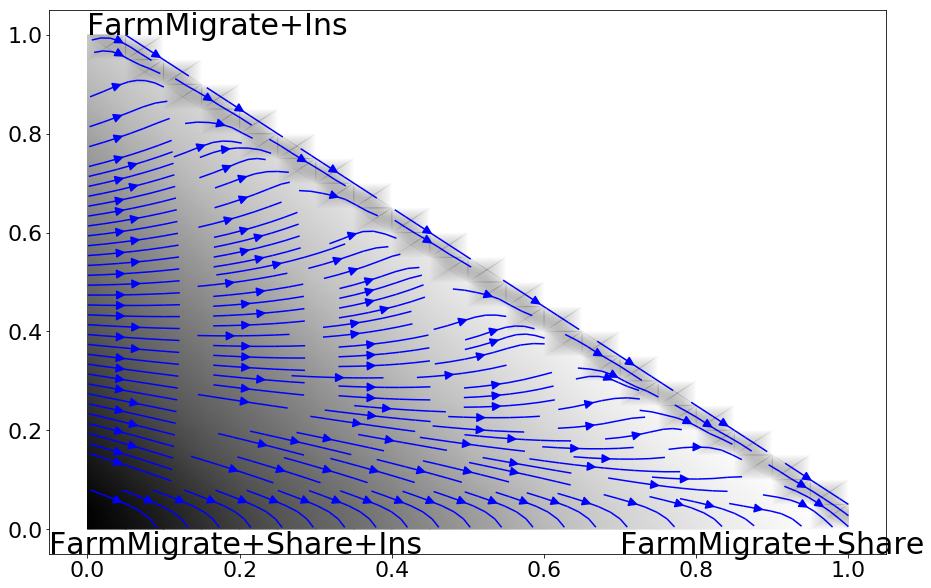

In [11]:
#Plot
X, Y = np.meshgrid(x, y)
strategy_dict = {'Farm': 0, 'Farm+Share': 1, 'Farm+Ins': 2, 'Farm+Share+Ins': 3, 'FarmMigrate': 4, 'FarmMigrate+Share': 5, 'FarmMigrate+Ins': 6, 'FarmMigrate+Share+Ins': 7, '': 8}
color_dict = {'Farm': 'blue', 'Farm+Share': 'green', 'Farm+Ins': 'purple', 'Farm+Share+Ins': 'pink', 'FarmMigrate': 'orange', 'FarmMigrate+Share': 'red', 'FarmMigrate+Ins': 'brown', 'FarmMigrate+Share+Ins': 'gray', '': 'white'}
z = np.zeros((steps, steps))
for a in range(steps):
    for b in range(steps):
        z[a,b] = strategy_dict[max_value[a][b]]
        
level_labels=[]
bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        
f, ax = plt.subplots(figsize=[15,10])

c = plt.pcolormesh(X, Y, social_util, shading='gouraud', cmap='Greys')
ax.streamplot(X, Y, x_grad, y_grad, color='blue', arrowstyle='simple', arrowsize = 1.5, maxlength=0.2, density=(1.75, 1.75))

#ax.quiver(X, Y, x_grad, y_grad, scale=40)

ax.set_ylim([-0.05,1.05])
ax.set_xlim([-0.05,1.05])
#ax.set_ylabel(str(strategy_y), size=20)

plt.text(-0.05, -0.05, str(strategy_z), size=30)
plt.text(0.7, -0.05, str(strategy_x), size=30)
plt.text(0.0, 1.0, str(strategy_y), size=30)
plt.xticks(size=22)
plt.yticks(size=22)
plt.show()

#plt.savefig(str(utility_function) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov) + '_Streamflow.png', bbox_inches='tight')
